In [1]:
%matplotlib inline
import geopandas as gpd
import datacube
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
sys.path.append('./utils')
import jncc_utils # jncc utils file containing helper functions from open data cube resources
from datacube.utils import masking
import pandas as pd
import calendar
# you can remove this is you want to see any warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
dc = datacube.Datacube()

<AxesSubplot:>

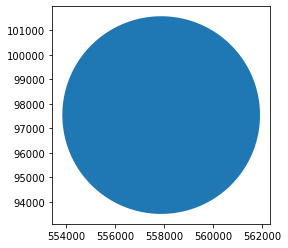

In [3]:
# read in NFI data from SDNP and plot
gdf = gpd.read_file('./data/sample.shp')
gdf.plot()

In [4]:
# use gdf bounds as extent for datacube query
query = {
    'time': ('2022-05-01','2022-07-31'),
    'output_crs': 'epsg:27700',
    'x': (gdf.total_bounds[0], gdf.total_bounds[2]),
    'y': (gdf.total_bounds[1], gdf.total_bounds[3]),
    'crs': 'epsg:27700',
    'resolution': (-10,10),
    'measurements':('green', 'fmask', 'nir2')
}

ds = dc.load(product='sentinel2',
            dask_chunks = {},
            **query)

In [5]:
ds

<xarray.Dataset>
Dimensions:      (time: 26, y: 808, x: 808)
Coordinates:
  * time         (time) datetime64[ns] 2022-05-03T10:56:21 ... 2022-07-27T10:...
  * y            (y) float64 1.016e+05 1.016e+05 ... 9.352e+04 9.35e+04
  * x            (x) float64 5.538e+05 5.538e+05 ... 5.619e+05 5.619e+05
    spatial_ref  int32 27700
Data variables:
    green        (time, y, x) uint16 dask.array<chunksize=(1, 808, 808), meta=np.ndarray>
    fmask        (time, y, x) uint8 dask.array<chunksize=(1, 808, 808), meta=np.ndarray>
    nir2         (time, y, x) uint16 dask.array<chunksize=(1, 808, 808), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

In [6]:
times = list(ds.time.values)
percentage_list=[]
for count, value in enumerate(times):
    data = ds.fmask.isel(time=count).values
    data2 = xr.where(data == 2, 1, data)
    data3 = data2.mean()
    percentage_list.append(data3)

data = {"times": times,
            "clean_percentage": percentage_list}

df = pd.DataFrame(data=data, columns=["times", "clean_percentage"])
df

,times,clean_percentage
0,2022-05-03 10:56:21,0.998027
1,2022-05-06 11:06:21,0.386491
2,2022-05-08 10:56:19,0.170409
3,2022-05-11 11:06:19,1.000000
4,2022-05-13 10:56:21,1.000000
5,2022-05-16 11:06:31,0.999516
6,2022-05-21 11:06:19,0.670386
7,2022-05-28 10:56:19,0.904283
8,2022-05-31 11:06:19,0.144269
9,2022-06-02 10:56:31,0.450837


In [7]:
ds = masking.mask_invalid_data(ds)

ds

<xarray.Dataset>
Dimensions:      (time: 26, y: 808, x: 808)
Coordinates:
  * time         (time) datetime64[ns] 2022-05-03T10:56:21 ... 2022-07-27T10:...
  * y            (y) float64 1.016e+05 1.016e+05 ... 9.352e+04 9.35e+04
  * x            (x) float64 5.538e+05 5.538e+05 ... 5.619e+05 5.619e+05
    spatial_ref  int32 27700
Data variables:
    green        (time, y, x) float64 dask.array<chunksize=(1, 808, 808), meta=np.ndarray>
    fmask        (time, y, x) float64 dask.array<chunksize=(1, 808, 808), meta=np.ndarray>
    nir2         (time, y, x) float64 dask.array<chunksize=(1, 808, 808), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

In [8]:
plot1 = ds.green.isel(time=0)
mask = jncc_utils.xr_rasterize(gdf, plot1)
masked_da = ds.where(mask)

Rasterizing to match xarray.DataArray dimensions (808, 808) and projection system/CRS (e.g. EPSG:27700)


Which slice do you want?

In [9]:
# get the lowest cloud percentage as example?
index_required = df['clean_percentage'].argmin()

In [11]:
single_slice = masked_da.isel(time = index_required)
single_slice

<xarray.Dataset>
Dimensions:      (y: 808, x: 808)
Coordinates:
    time         datetime64[ns] 2022-06-07T10:56:19
  * y            (y) float64 1.016e+05 1.016e+05 ... 9.352e+04 9.35e+04
  * x            (x) float64 5.538e+05 5.538e+05 ... 5.619e+05 5.619e+05
    spatial_ref  int32 27700
Data variables:
    green        (y, x) float64 dask.array<chunksize=(808, 808), meta=np.ndarray>
    fmask        (y, x) float64 dask.array<chunksize=(808, 808), meta=np.ndarray>
    nir2         (y, x) float64 dask.array<chunksize=(808, 808), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

In [12]:
clean = single_slice.drop_vars("fmask")
clean

<xarray.Dataset>
Dimensions:      (y: 808, x: 808)
Coordinates:
    time         datetime64[ns] 2022-06-07T10:56:19
  * y            (y) float64 1.016e+05 1.016e+05 ... 9.352e+04 9.35e+04
  * x            (x) float64 5.538e+05 5.538e+05 ... 5.619e+05 5.619e+05
    spatial_ref  int32 27700
Data variables:
    green        (y, x) float64 dask.array<chunksize=(808, 808), meta=np.ndarray>
    nir2         (y, x) float64 dask.array<chunksize=(808, 808), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

In [13]:
jncc_utils.export_slice_to_geotiff(clean, 'sample_image.tif')